In [1]:
!pip install unsloth[inference]

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/561.5 kB ? eta -:--:--
   ---------------------------------------- 561.5/561.5 kB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/26.2 MB ? eta -:--:--
   -- ------------------------------------- 1.6/26.2 MB 7.0 MB/s eta 0:00:04
   ---- ----------------------------------- 3.1/26.2 MB 7.1 MB/s eta 0:00:04
   ------- -------------------------------- 4.7/26.2 MB 7.3 MB/s eta 0:00:03
   --------- ------------------------------ 6.0/26.2 MB 7.2 MB/s eta 0:00:03
   ----------- ---------------------------- 7.3/26.2 MB 7.3 MB/s eta 0:00:03
   ------------- -------------------------- 9.2/26.2 MB 7.3 MB/s eta 0:00:03
   ---------------- -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
langchain 0.3.1 requires tenacity!=8.4.0,<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-community 0.3.1 requires tenacity!=8.4.0,<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-core 0.3.6 requires tenacity!=8.4.0,<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
pettingzoo 1.25.0 requires gymnasium>=1.0.0, but you have gymnasium 0.28.1 which is incompatible.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.5 which is incompatible.
streamlit 1.28.1 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.
streamlit 1.28.1 requires proto

In [34]:
!pip install unsloth


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install google-generativeai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [4]:
def load_training_data(checkpoint_path):
    """Extract training metrics from trainer_state.json"""
    trainer_state_path = Path(checkpoint_path) / "trainer_state.json"
    
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    
    # Extract log history
    log_history = trainer_state.get('log_history', [])
    
    # Separate training and evaluation logs
    train_logs = []
    eval_logs = []
    
    for entry in log_history:
        if 'train_loss' in entry:
            train_logs.append(entry)
        elif 'eval_loss' in entry:
            eval_logs.append(entry)
    
    return {
        'train_logs': train_logs,
        'eval_logs': eval_logs,
        'trainer_state': trainer_state
    }

In [5]:
def plot_training_curves(data, experiment_name="Experiment"):
    """Create comprehensive training curve visualizations"""
    
    train_logs = data['train_logs']
    eval_logs = data['eval_logs']
    
    # Convert to DataFrames for easier plotting
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - Training Dynamics Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss Curves
    ax1 = axes[0, 0]
    if 'step' in train_df.columns and 'train_loss' in train_df.columns:
        ax1.plot(train_df['step'], train_df['train_loss'], label='Train Loss', color='blue', alpha=0.7)
    if 'step' in eval_df.columns and 'eval_loss' in eval_df.columns:
        ax1.plot(eval_df['step'], eval_df['eval_loss'], label='Eval Loss', color='red', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale for loss
    
    # Plot 2: Learning Rate Schedule
    ax2 = axes[0, 1]
    if 'step' in train_df.columns and 'learning_rate' in train_df.columns:
        ax2.plot(train_df['step'], train_df['learning_rate'], color='green', linewidth=2)
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reward Evolution (if available)
    ax3 = axes[1, 0]
    reward_columns = [col for col in train_df.columns if 'reward' in col.lower()]
    if reward_columns:
        for col in reward_columns:
            ax3.plot(train_df['step'], train_df[col], label=col, alpha=0.8)
        ax3.set_xlabel('Training Steps')
        ax3.set_ylabel('Reward')
        ax3.set_title('Reward Evolution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No Reward Data Found', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Reward Evolution (No Data)')
    
    # Plot 4: Training Speed Analysis
    ax4 = axes[1, 1]
    if 'step' in train_df.columns and len(train_df) > 1:
        # Calculate steps per second
        step_diffs = train_df['step'].diff().dropna()
        time_diffs = np.arange(1, len(step_diffs) + 1)  # Approximate time
        
        if 'epoch' in train_df.columns:
            ax4.scatter(train_df['epoch'], train_df['step'], alpha=0.6, color='purple')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Training Steps')
            ax4.set_title('Training Progress (Steps per Epoch)')
        else:
            ax4.plot(train_df['step'], label='Training Steps', color='purple')
            ax4.set_xlabel('Log Entry')
            ax4.set_ylabel('Step Count')
            ax4.set_title('Training Step Progress')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


In [6]:
def analyze_training_stats(data, experiment_name="Experiment"):
    """Extract key statistics from training data"""
    
    train_logs = data['train_logs']
    eval_logs = data['eval_logs']
    trainer_state = data['trainer_state']
    
    stats = {
        'experiment_name': experiment_name,
        'total_steps': len(train_logs),
        'total_epochs': trainer_state.get('epoch', 0),
    }
    
    # Loss statistics
    if train_logs:
        train_losses = [log.get('train_loss', 0) for log in train_logs]
        stats['final_train_loss'] = train_losses[-1] if train_losses else 0
        stats['min_train_loss'] = min(train_losses) if train_losses else 0
        stats['loss_reduction'] = (train_losses[0] - train_losses[-1]) / train_losses[0] if len(train_losses) > 1 else 0
    
    if eval_logs:
        eval_losses = [log.get('eval_loss', 0) for log in eval_logs]
        stats['final_eval_loss'] = eval_losses[-1] if eval_losses else 0
        stats['min_eval_loss'] = min(eval_losses) if eval_losses else 0
        stats['best_eval_step'] = eval_logs[np.argmin(eval_losses)].get('step', 0) if eval_losses else 0
    
    # Reward statistics (if available)
    reward_columns = []
    if train_logs:
        reward_columns = [key for key in train_logs[0].keys() if 'reward' in key.lower()]
        for col in reward_columns:
            rewards = [log.get(col, 0) for log in train_logs]
            stats[f'{col}_final'] = rewards[-1] if rewards else 0
            stats[f'{col}_max'] = max(rewards) if rewards else 0
            stats[f'{col}_mean'] = np.mean(rewards) if rewards else 0
    
    return stats, reward_columns

In [8]:
def print_experiment_summary(stats):
    """Print formatted experiment summary"""
    print(f"\n{'='*60}")
    print(f"EXPERIMENT SUMMARY: {stats['experiment_name']}")
    print(f"{'='*60}")
    print(f"Training Progress:")
    print(f"   Total Steps: {stats['total_steps']:,}")
    print(f"   Total Epochs: {stats.get('total_epochs', 0):.1f}")
    
    print(f"\nLoss Performance:")
    print(f"   Final Train Loss: {stats.get('final_train_loss', 0):.6f}")
    print(f"   Final Eval Loss: {stats.get('final_eval_loss', 0):.6f}")
    print(f"   Min Train Loss: {stats.get('min_train_loss', 0):.6f}")
    print(f"   Loss Reduction: {stats.get('loss_reduction', 0)*100:.2f}%")
    
    # Print reward stats if available
    reward_keys = [key for key in stats.keys() if 'reward' in key]
    if reward_keys:
        print(f"\nReward Statistics:")
        for key in reward_keys:
            print(f"   {key}: {stats[key]:.4f}")

In [9]:
def analyze_single_experiment(checkpoint_path, experiment_name):
    """Complete analysis of a single experiment"""
    
    print(f"Analyzing: {experiment_name}")
    print(f"Path: {checkpoint_path}")
    
    # Load data
    try:
        data = load_training_data(checkpoint_path)
        print(f"Successfully loaded training data")
        print(f"   - Train logs: {len(data['train_logs'])} entries")
        print(f"   - Eval logs: {len(data['eval_logs'])} entries")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None
    
    # Generate statistics
    stats, reward_columns = analyze_training_stats(data, experiment_name)
    
    # Print summary
    print_experiment_summary(stats)
    
    # Generate plots
    fig = plot_training_curves(data, experiment_name)
    
    # Show available metrics
    if data['train_logs']:
        available_metrics = list(data['train_logs'][0].keys())
        print(f"\nAvailable Metrics: {available_metrics}")
    
    return data, stats


Analyzing: Math Hard Rewards
Path: outputs_mathhard\math_hard_rewards\checkpoint-100
Successfully loaded training data
   - Train logs: 0 entries
   - Eval logs: 0 entries

EXPERIMENT SUMMARY: Math Hard Rewards
Training Progress:
   Total Steps: 0
   Total Epochs: 0.2

Loss Performance:
   Final Train Loss: 0.000000
   Final Eval Loss: 0.000000
   Min Train Loss: 0.000000
   Loss Reduction: 0.00%


C:\Users\farha\AppData\Local\Temp\ipykernel_22980\2111941077.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


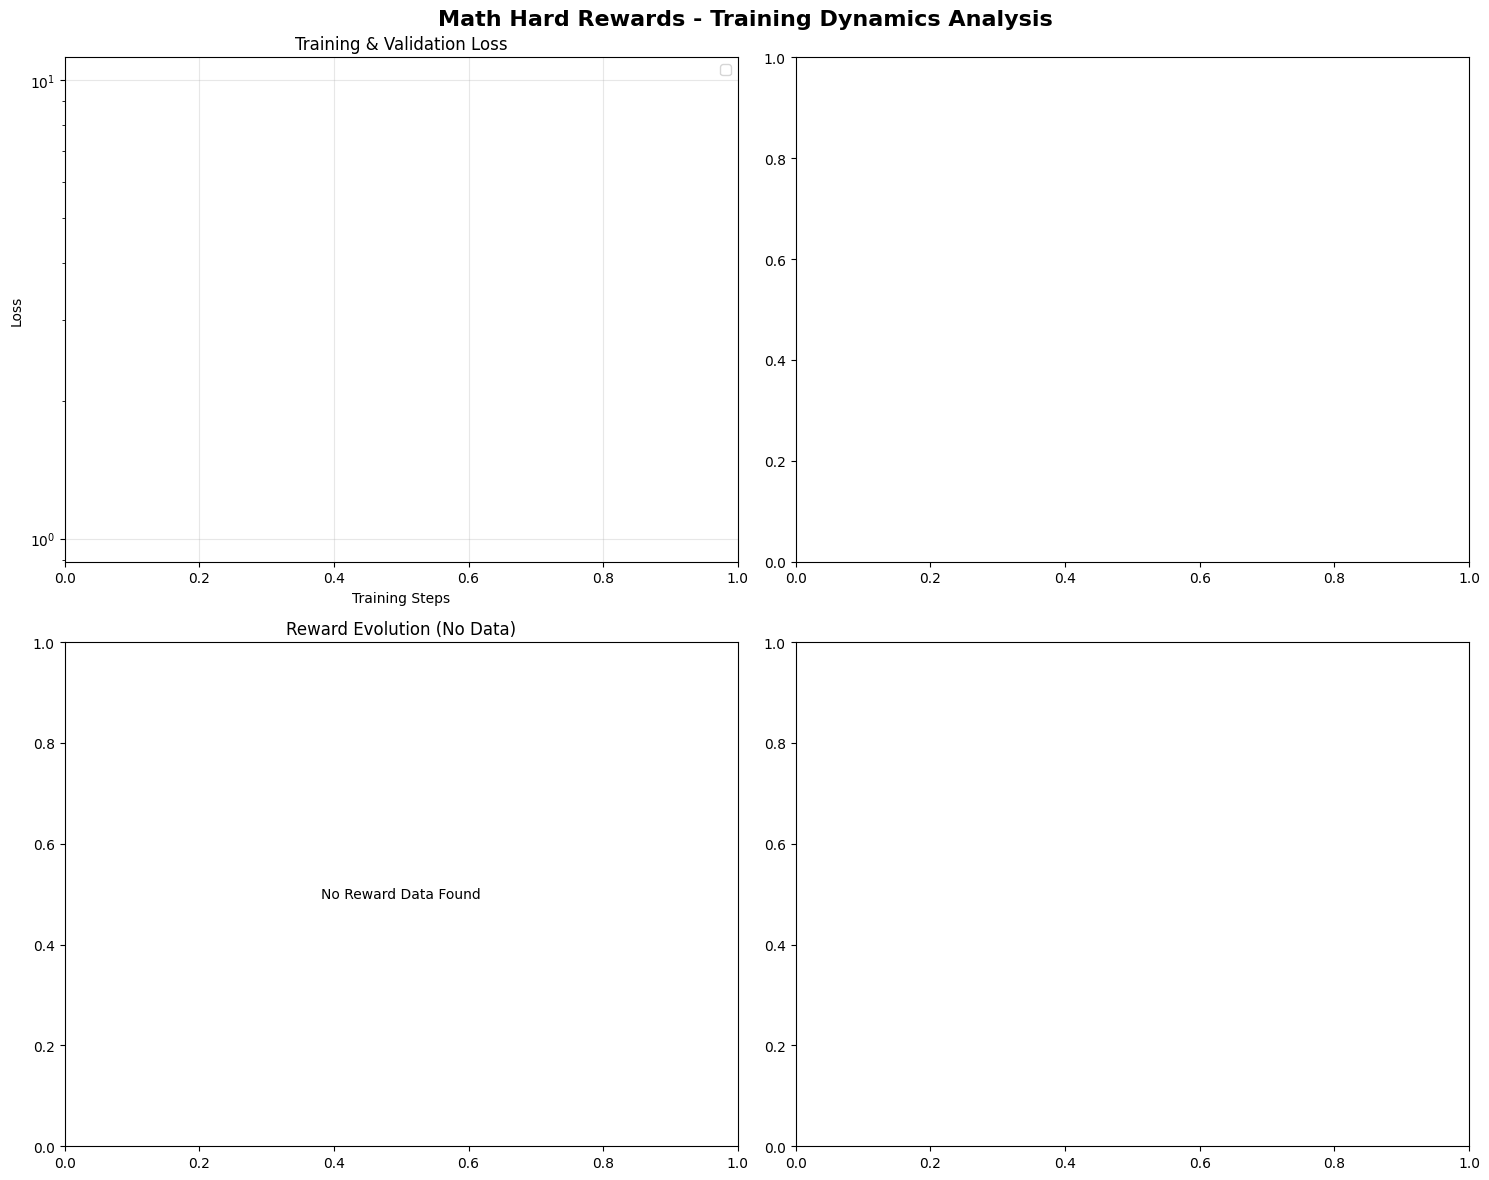

In [11]:
checkpoint_path = r"outputs_mathhard\math_hard_rewards\checkpoint-100"
experiment_name = "Math Hard Rewards"

data, stats = analyze_single_experiment(checkpoint_path, experiment_name)
plt.show()

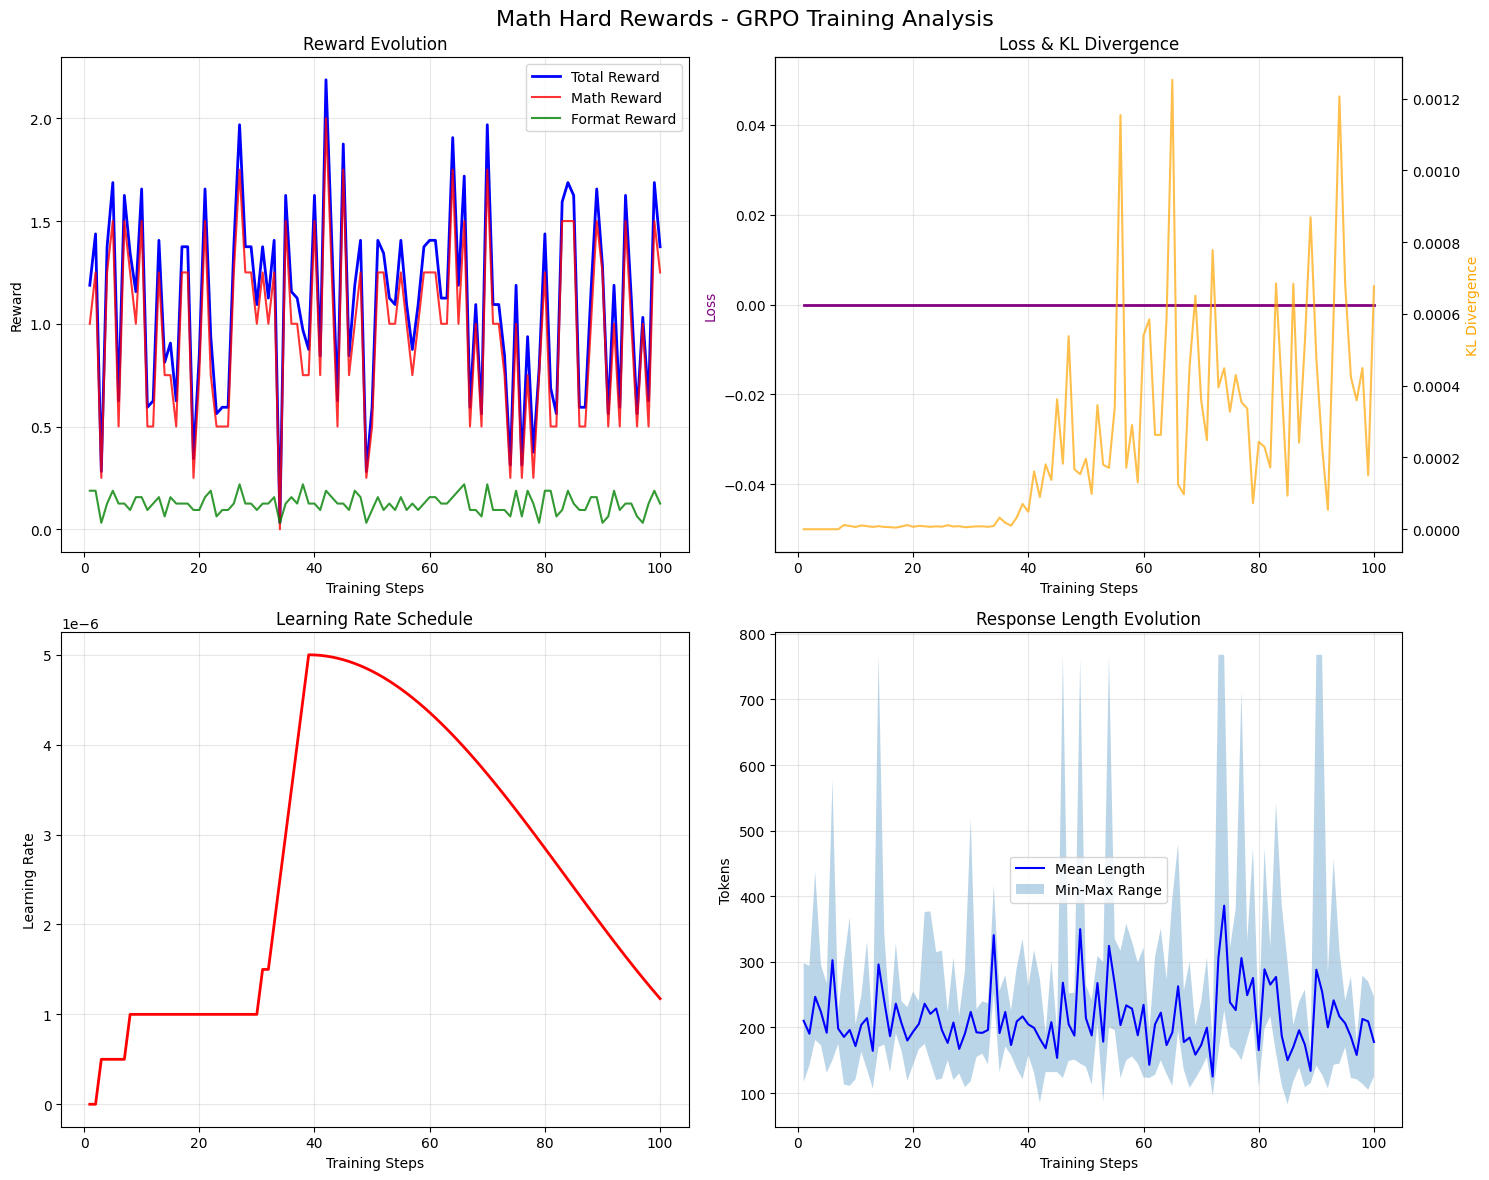

Final reward: 1.375
Math reward progress: 1.000 -> 1.250
Final KL divergence: 0.000677


In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_grpo_training_data(checkpoint_path):
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
    
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    
    # All entries are training logs in GRPO format
    log_history = trainer_state.get('log_history', [])
    
    return {
        'log_history': log_history,
        'trainer_state': trainer_state
    }

def plot_grpo_training_curves(data, experiment_name):
    log_history = data['log_history']
    df = pd.DataFrame(log_history)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - GRPO Training Analysis', fontsize=16)
    
    # Plot 1: Reward Evolution
    ax1 = axes[0, 0]
    ax1.plot(df['step'], df['reward'], label='Total Reward', color='blue', linewidth=2)
    ax1.plot(df['step'], df['rewards/math_hard_reward/mean'], label='Math Reward', color='red', alpha=0.8)
    ax1.plot(df['step'], df['rewards/format_reward_func/mean'], label='Format Reward', color='green', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss and KL Divergence
    ax2 = axes[0, 1]
    ax2.plot(df['step'], df['loss'], label='Loss', color='purple', linewidth=2)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['step'], df['kl'], label='KL Divergence', color='orange', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss', color='purple')
    ax2_twin.set_ylabel('KL Divergence', color='orange')
    ax2.set_title('Loss & KL Divergence')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    ax3 = axes[1, 0]
    ax3.plot(df['step'], df['learning_rate'], color='red', linewidth=2)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Completion Length Stats
    ax4 = axes[1, 1]
    ax4.plot(df['step'], df['completion_length'], label='Mean Length', color='blue')
    ax4.fill_between(df['step'], 
                     df['completions/min_length'], 
                     df['completions/max_length'], 
                     alpha=0.3, label='Min-Max Range')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Tokens')
    ax4.set_title('Response Length Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Usage:
checkpoint_path = r"outputs_mathhard\math_hard_rewards\checkpoint-100"
data = load_grpo_training_data(checkpoint_path)
fig = plot_grpo_training_curves(data, "Math Hard Rewards")
plt.show()

# Print key stats
df = pd.DataFrame(data['log_history'])
print(f"Final reward: {df['reward'].iloc[-1]:.3f}")
print(f"Math reward progress: {df['rewards/math_hard_reward/mean'].iloc[0]:.3f} -> {df['rewards/math_hard_reward/mean'].iloc[-1]:.3f}")
print(f"Final KL divergence: {df['kl'].iloc[-1]:.6f}")

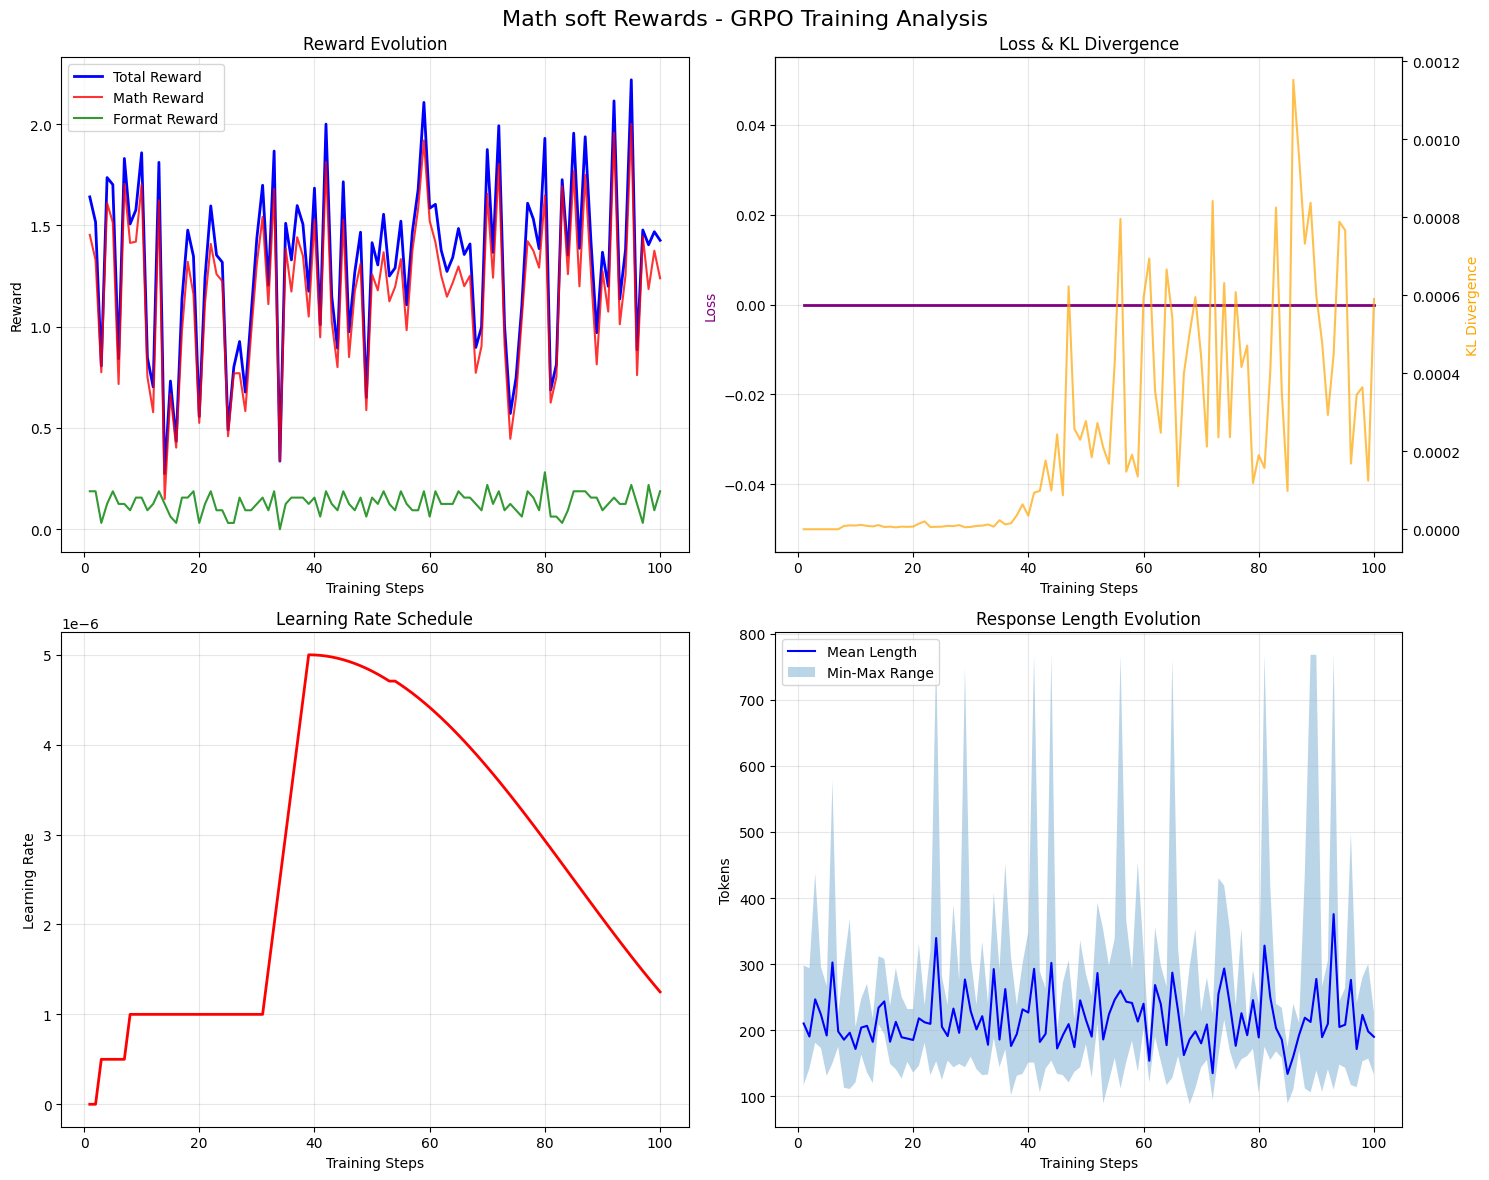

Final reward: 1.426
Math reward progress: 1.453 -> 1.239
Final KL divergence: 0.000590


In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_grpo_training_data(checkpoint_path):
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
    
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    
    # All entries are training logs in GRPO format
    log_history = trainer_state.get('log_history', [])
    
    return {
        'log_history': log_history,
        'trainer_state': trainer_state
    }

def plot_grpo_training_curves(data, experiment_name):
    log_history = data['log_history']
    df = pd.DataFrame(log_history)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - GRPO Training Analysis', fontsize=16)
    
    # Plot 1: Reward Evolution
    ax1 = axes[0, 0]
    ax1.plot(df['step'], df['reward'], label='Total Reward', color='blue', linewidth=2)
    ax1.plot(df['step'], df['rewards/math_soft_reward/mean'], label='Math Reward', color='red', alpha=0.8)
    ax1.plot(df['step'], df['rewards/format_reward_func/mean'], label='Format Reward', color='green', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss and KL Divergence
    ax2 = axes[0, 1]
    ax2.plot(df['step'], df['loss'], label='Loss', color='purple', linewidth=2)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['step'], df['kl'], label='KL Divergence', color='orange', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss', color='purple')
    ax2_twin.set_ylabel('KL Divergence', color='orange')
    ax2.set_title('Loss & KL Divergence')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    ax3 = axes[1, 0]
    ax3.plot(df['step'], df['learning_rate'], color='red', linewidth=2)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Completion Length Stats
    ax4 = axes[1, 1]
    ax4.plot(df['step'], df['completion_length'], label='Mean Length', color='blue')
    ax4.fill_between(df['step'], 
                     df['completions/min_length'], 
                     df['completions/max_length'], 
                     alpha=0.3, label='Min-Max Range')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Tokens')
    ax4.set_title('Response Length Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Usage:
checkpoint_path = r"outputs_mathsoft\math_soft_rewards\checkpoint-100"
data = load_grpo_training_data(checkpoint_path)
fig = plot_grpo_training_curves(data, "Math soft Rewards")
plt.show()

# Print key stats
df = pd.DataFrame(data['log_history'])
print(f"Final reward: {df['reward'].iloc[-1]:.3f}")
print(f"Math reward progress: {df['rewards/math_soft_reward/mean'].iloc[0]:.3f} -> {df['rewards/math_soft_reward/mean'].iloc[-1]:.3f}")
print(f"Final KL divergence: {df['kl'].iloc[-1]:.6f}")

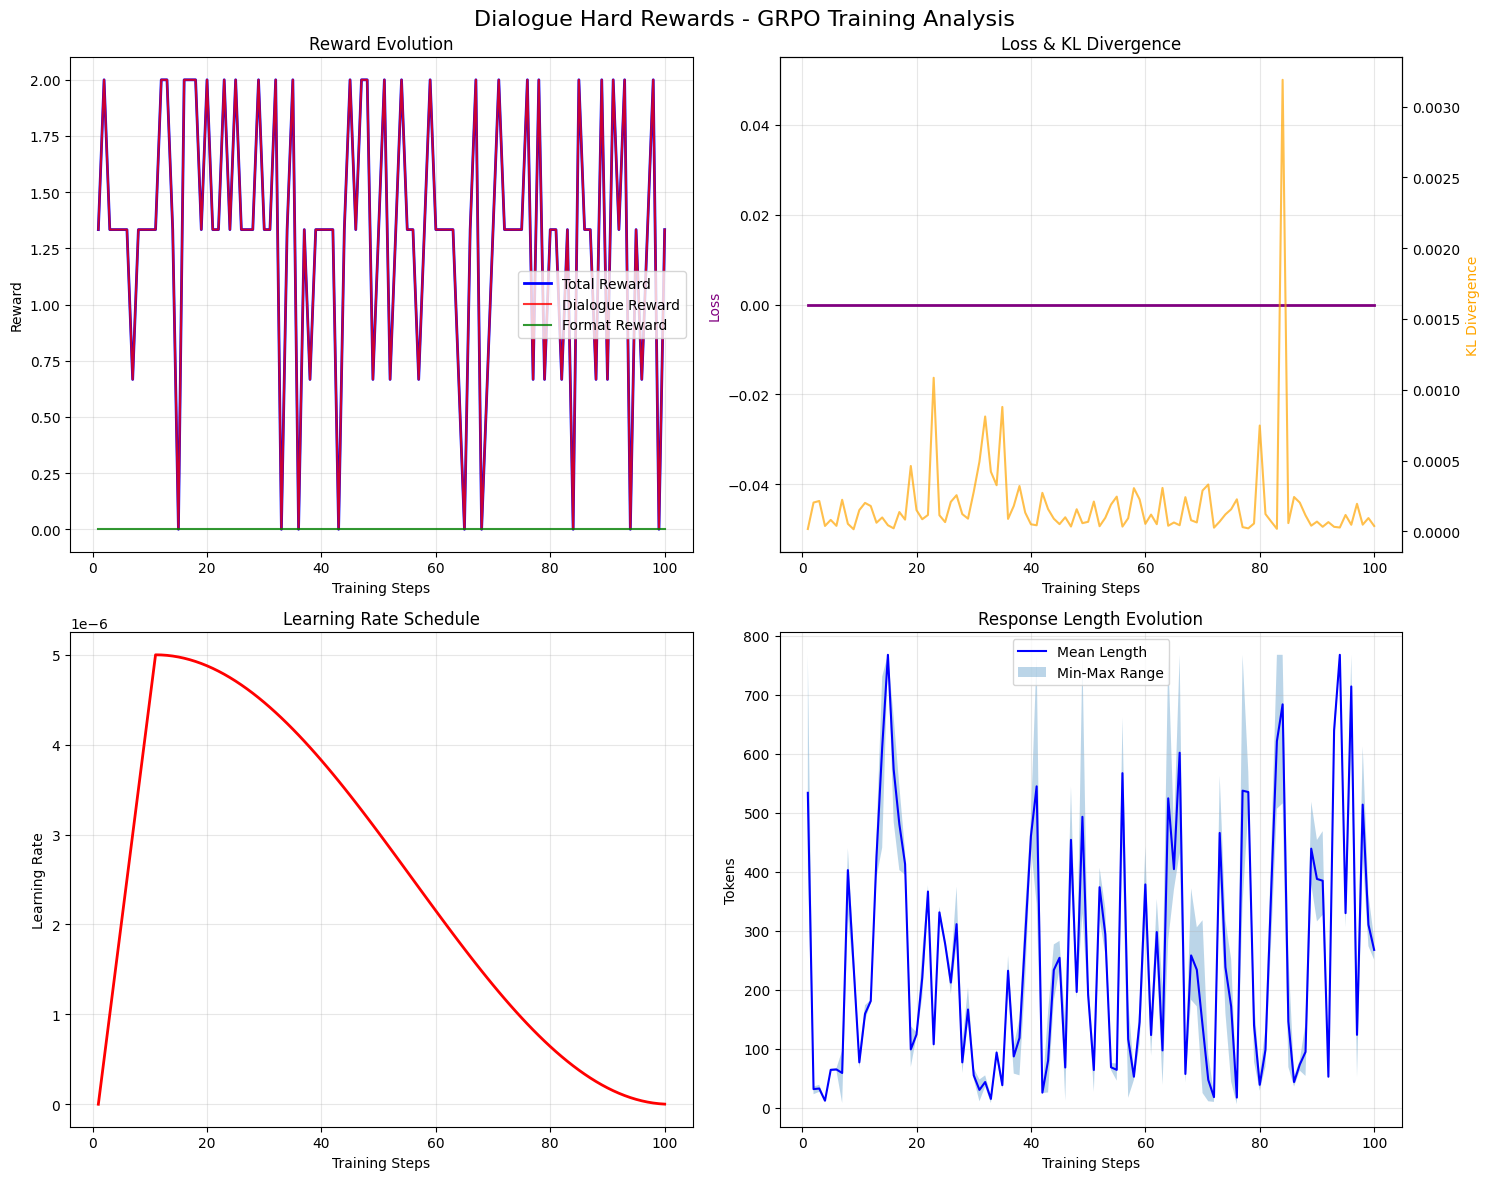

Final reward: 1.333
Dialogue reward progress: 1.333 -> 1.333
Final KL divergence: 0.000037


In [43]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_grpo_training_data(checkpoint_path):
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
    
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    
    # All entries are training logs in GRPO format
    log_history = trainer_state.get('log_history', [])
    
    return {
        'log_history': log_history,
        'trainer_state': trainer_state
    }

def plot_grpo_dialogue_curves(data, experiment_name):
    log_history = data['log_history']
    df = pd.DataFrame(log_history)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - GRPO Training Analysis', fontsize=16)
    
    # Plot 1: Reward Evolution - FIXED COLUMN NAMES
    ax1 = axes[0, 0]
    ax1.plot(df['step'], df['reward'], label='Total Reward', color='blue', linewidth=2)
    ax1.plot(df['step'], df['rewards/dialogue_hard_reward_gemini/mean'], label='Dialogue Reward', color='red', alpha=0.8)
    ax1.plot(df['step'], df['rewards/format_reward_func/mean'], label='Format Reward', color='green', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Evolution')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss and KL Divergence
    ax2 = axes[0, 1]
    ax2.plot(df['step'], df['loss'], label='Loss', color='purple', linewidth=2)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['step'], df['kl'], label='KL Divergence', color='orange', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss', color='purple')
    ax2_twin.set_ylabel('KL Divergence', color='orange')
    ax2.set_title('Loss & KL Divergence')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    ax3 = axes[1, 0]
    ax3.plot(df['step'], df['learning_rate'], color='red', linewidth=2)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Completion Length Stats
    ax4 = axes[1, 1]
    ax4.plot(df['step'], df['completion_length'], label='Mean Length', color='blue')
    ax4.fill_between(df['step'], 
                     df['completions/min_length'], 
                     df['completions/max_length'], 
                     alpha=0.3, label='Min-Max Range')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Tokens')
    ax4.set_title('Response Length Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Dialogue Hard Rewards
checkpoint_path = r"outputs_dialoguehard\dialogue_hard_rewards\checkpoint-100"
data_dialogue_hard = load_grpo_training_data(checkpoint_path)
fig = plot_grpo_training_curves(data_dialogue_hard, "Dialogue Hard Rewards")
plt.show()

df = pd.DataFrame(data_dialogue_hard['log_history'])
print(f"Final reward: {df['reward'].iloc[-1]:.3f}")
print(f"Dialogue reward progress: {df['rewards/dialogue_hard_reward_gemini/mean'].iloc[0]:.3f} -> {df['rewards/dialogue_hard_reward_gemini/mean'].iloc[-1]:.3f}")
print(f"Final KL divergence: {df['kl'].iloc[-1]:.6f}")

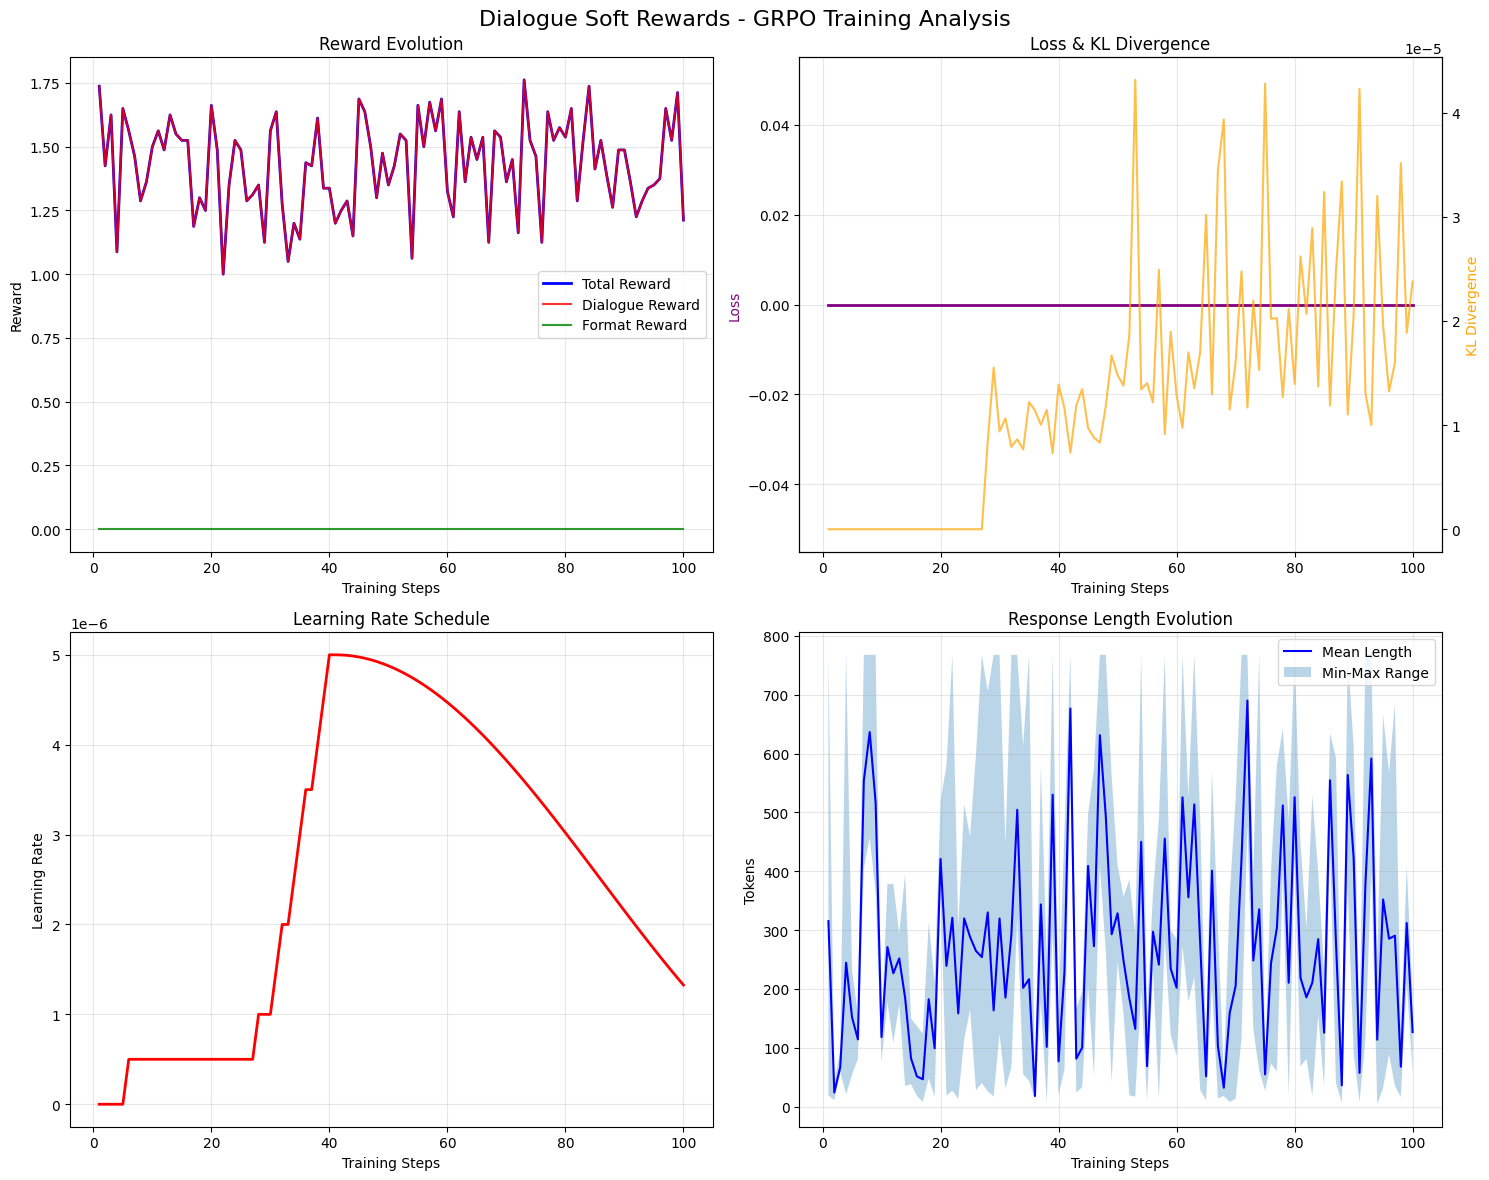

Final reward: 1.212
Dialogue reward progress: 1.737 -> 1.212
Final KL divergence: 0.000024


In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_grpo_training_data(checkpoint_path):
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
    
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    
    # All entries are training logs in GRPO format
    log_history = trainer_state.get('log_history', [])
    
    return {
        'log_history': log_history,
        'trainer_state': trainer_state
    }

def plot_grpo_dialogue_curves(data, experiment_name):
    log_history = data['log_history']
    df = pd.DataFrame(log_history)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - GRPO Training Analysis', fontsize=16)
    
    # Plot 1: Reward Evolution - FIXED COLUMN NAMES
    ax1 = axes[0, 0]
    ax1.plot(df['step'], df['reward'], label='Total Reward', color='blue', linewidth=2)
    ax1.plot(df['step'], df['rewards/dialogue_soft_reward_gemini/mean'], label='Dialogue Reward', color='red', alpha=0.8)
    ax1.plot(df['step'], df['rewards/format_reward_func/mean'], label='Format Reward', color='green', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss and KL Divergence
    ax2 = axes[0, 1]
    ax2.plot(df['step'], df['loss'], label='Loss', color='purple', linewidth=2)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['step'], df['kl'], label='KL Divergence', color='orange', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss', color='purple')
    ax2_twin.set_ylabel('KL Divergence', color='orange')
    ax2.set_title('Loss & KL Divergence')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    ax3 = axes[1, 0]
    ax3.plot(df['step'], df['learning_rate'], color='red', linewidth=2)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Completion Length Stats
    ax4 = axes[1, 1]
    ax4.plot(df['step'], df['completion_length'], label='Mean Length', color='blue')
    ax4.fill_between(df['step'], 
                     df['completions/min_length'], 
                     df['completions/max_length'], 
                     alpha=0.3, label='Min-Max Range')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Tokens')
    ax4.set_title('Response Length Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

checkpoint_path = r"outputs_dialoguesoft\dialogue_soft_rewards\checkpoint-100"
data_dialogue_soft = load_grpo_training_data(checkpoint_path)
fig = plot_grpo_dialogue_curves(data_dialogue_soft, "Dialogue Soft Rewards")  # Fixed function name
plt.show()

df = pd.DataFrame(data_dialogue_soft['log_history'])  # Fixed variable name
print(f"Final reward: {df['reward'].iloc[-1]:.3f}")
print(f"Dialogue reward progress: {df['rewards/dialogue_soft_reward_gemini/mean'].iloc[0]:.3f} -> {df['rewards/dialogue_soft_reward_gemini/mean'].iloc[-1]:.3f}")
print(f"Final KL divergence: {df['kl'].iloc[-1]:.6f}")

In [19]:
# Debug: See what reward columns actually exist in dialogue data
checkpoint_path = r"outputs_dialoguehard\dialogue_hard_rewards\checkpoint-100" 
data_dialogue_hard = load_grpo_training_data(checkpoint_path)
df = pd.DataFrame(data_dialogue_hard['log_history'])

# Show all column names that contain 'reward'
reward_columns = [col for col in df.columns if 'reward' in col]
print("Available reward columns:")
for col in reward_columns:
    print(f"  {col}")

# Show first row of data to see the structure
print(f"\nFirst log entry:")
print(df.iloc[0])

Available reward columns:
  frac_reward_zero_std
  reward
  reward_std
  rewards/dialogue_hard_reward_gemini/mean
  rewards/dialogue_hard_reward_gemini/std
  rewards/format_reward_func/mean
  rewards/format_reward_func/std

First log entry:
completion_length                            534.000000
completions/clipped_ratio                      0.333333
completions/max_length                       768.000000
completions/max_terminated_length            424.000000
completions/mean_length                      534.000000
completions/mean_terminated_length           417.000000
completions/min_length                       410.000000
completions/min_terminated_length            410.000000
epoch                                          0.001250
frac_reward_zero_std                           0.000000
grad_norm                                      0.188071
kl                                             0.000016
learning_rate                                  0.000000
loss                           

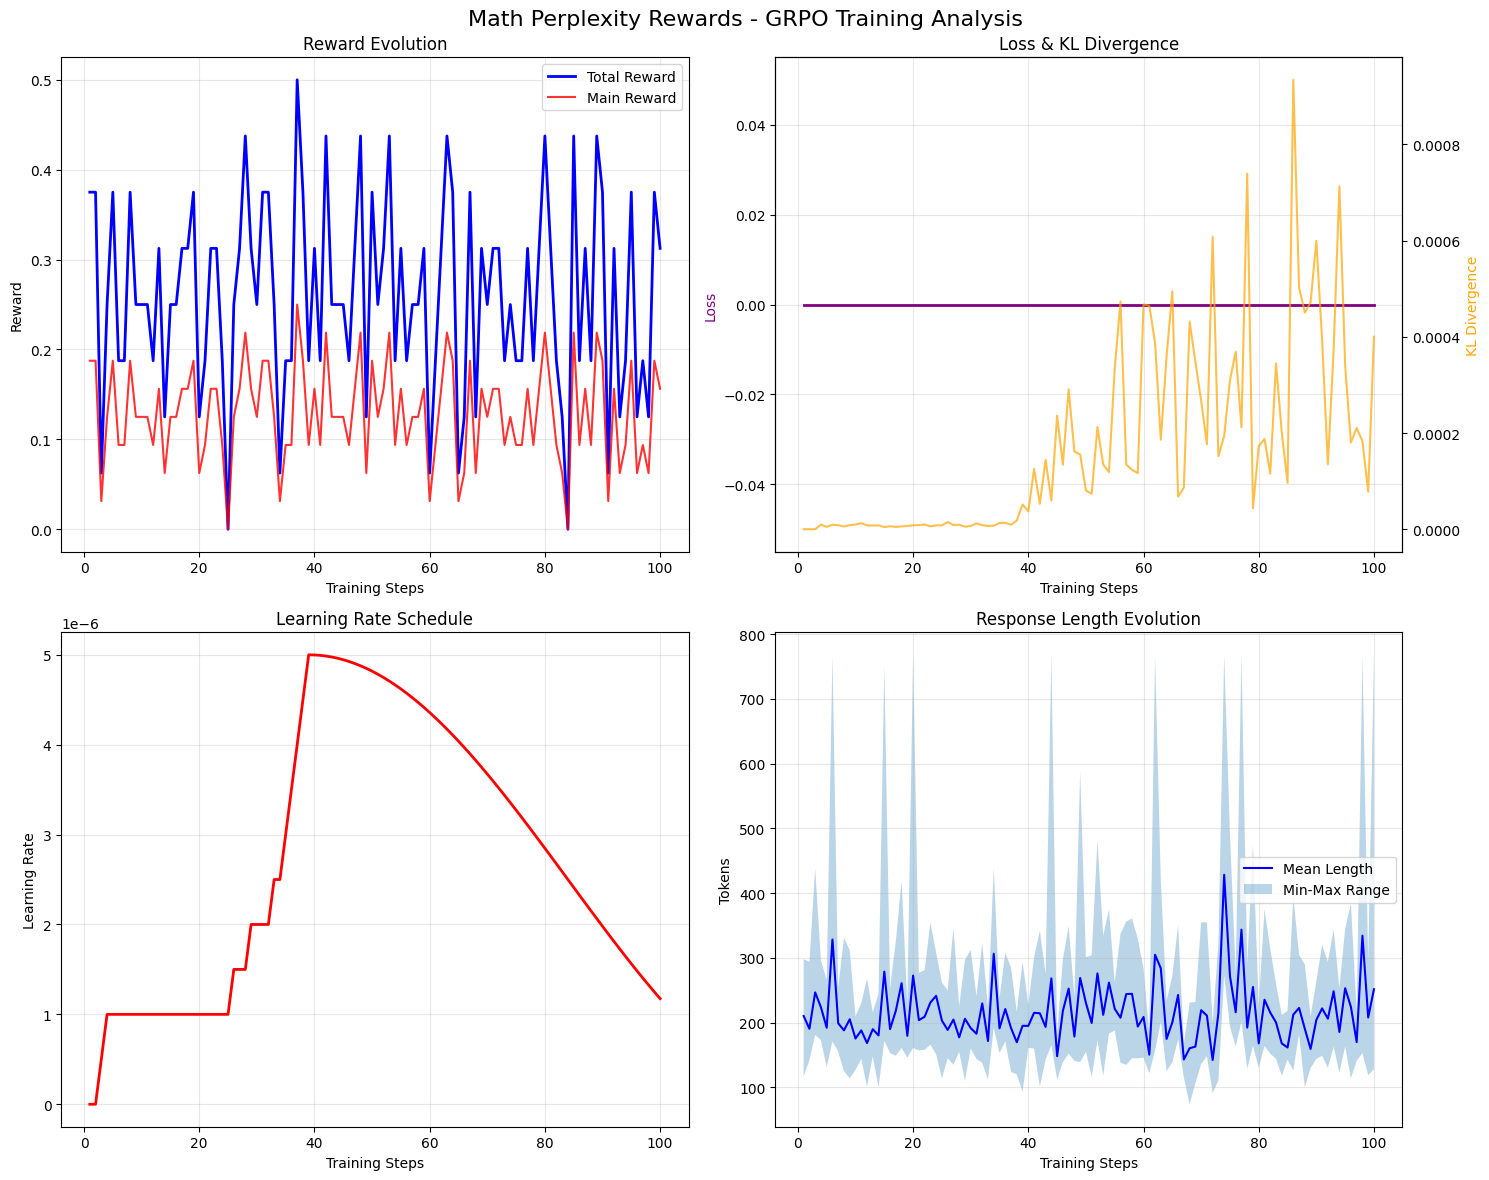

Final reward: 0.312
Math perplexity progress: 0.188 -> 0.156
Final KL divergence: 0.000400


In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def load_grpo_training_data(checkpoint_path):
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    log_history = trainer_state.get('log_history', [])
    return {'log_history': log_history, 'trainer_state': trainer_state}

def plot_grpo_curves(data, experiment_name):
    log_history = data['log_history']
    df = pd.DataFrame(log_history)
    
    # Auto-detect reward columns
    reward_columns = [col for col in df.columns if 'reward' in col and 'mean' in col and 'format' not in col]
    main_reward_col = reward_columns[0] if reward_columns else None
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{experiment_name} - GRPO Training Analysis', fontsize=16)
    
    # Plot 1: Reward Evolution
    ax1 = axes[0, 0]
    ax1.plot(df['step'], df['reward'], label='Total Reward', color='blue', linewidth=2)
    if main_reward_col:
        ax1.plot(df['step'], df[main_reward_col], label='Main Reward', color='red', alpha=0.8)
    if 'rewards/format_reward_func/mean' in df.columns:
        ax1.plot(df['step'], df['rewards/format_reward_func/mean'], label='Format Reward', color='green', alpha=0.8)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss and KL Divergence
    ax2 = axes[0, 1]
    ax2.plot(df['step'], df['loss'], label='Loss', color='purple', linewidth=2)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df['step'], df['kl'], label='KL Divergence', color='orange', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss', color='purple')
    ax2_twin.set_ylabel('KL Divergence', color='orange')
    ax2.set_title('Loss & KL Divergence')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    ax3 = axes[1, 0]
    ax3.plot(df['step'], df['learning_rate'], color='red', linewidth=2)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Completion Length Stats
    ax4 = axes[1, 1]
    ax4.plot(df['step'], df['completion_length'], label='Mean Length', color='blue')
    ax4.fill_between(df['step'], df['completions/min_length'], df['completions/max_length'], 
                     alpha=0.3, label='Min-Max Range')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Tokens')
    ax4.set_title('Response Length Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Test with math perplexity
checkpoint_path = r"outputs_math_perplexity\math_perplexity_rewards\checkpoint-100"
data_math_perplexity = load_grpo_training_data(checkpoint_path)
fig = plot_grpo_curves(data_math_perplexity, "Math Perplexity Rewards")
plt.show()

df = pd.DataFrame(data_math_perplexity['log_history'])
main_reward_col = 'rewards/wrapped_func/mean'  # The actual column name for math perplexity

print(f"Final reward: {df['reward'].iloc[-1]:.3f}")
print(f"Math perplexity progress: {df[main_reward_col].iloc[0]:.3f} -> {df[main_reward_col].iloc[-1]:.3f}")
print(f"Final KL divergence: {df['kl'].iloc[-1]:.6f}")

Loaded Math Hard: 100 steps
Loaded Math Soft: 100 steps
Loaded Math Perplexity: 100 steps
Loaded Dialogue Hard: 100 steps
Loaded Dialogue Soft: 100 steps
Loaded Dialogue Perplexity: 100 steps


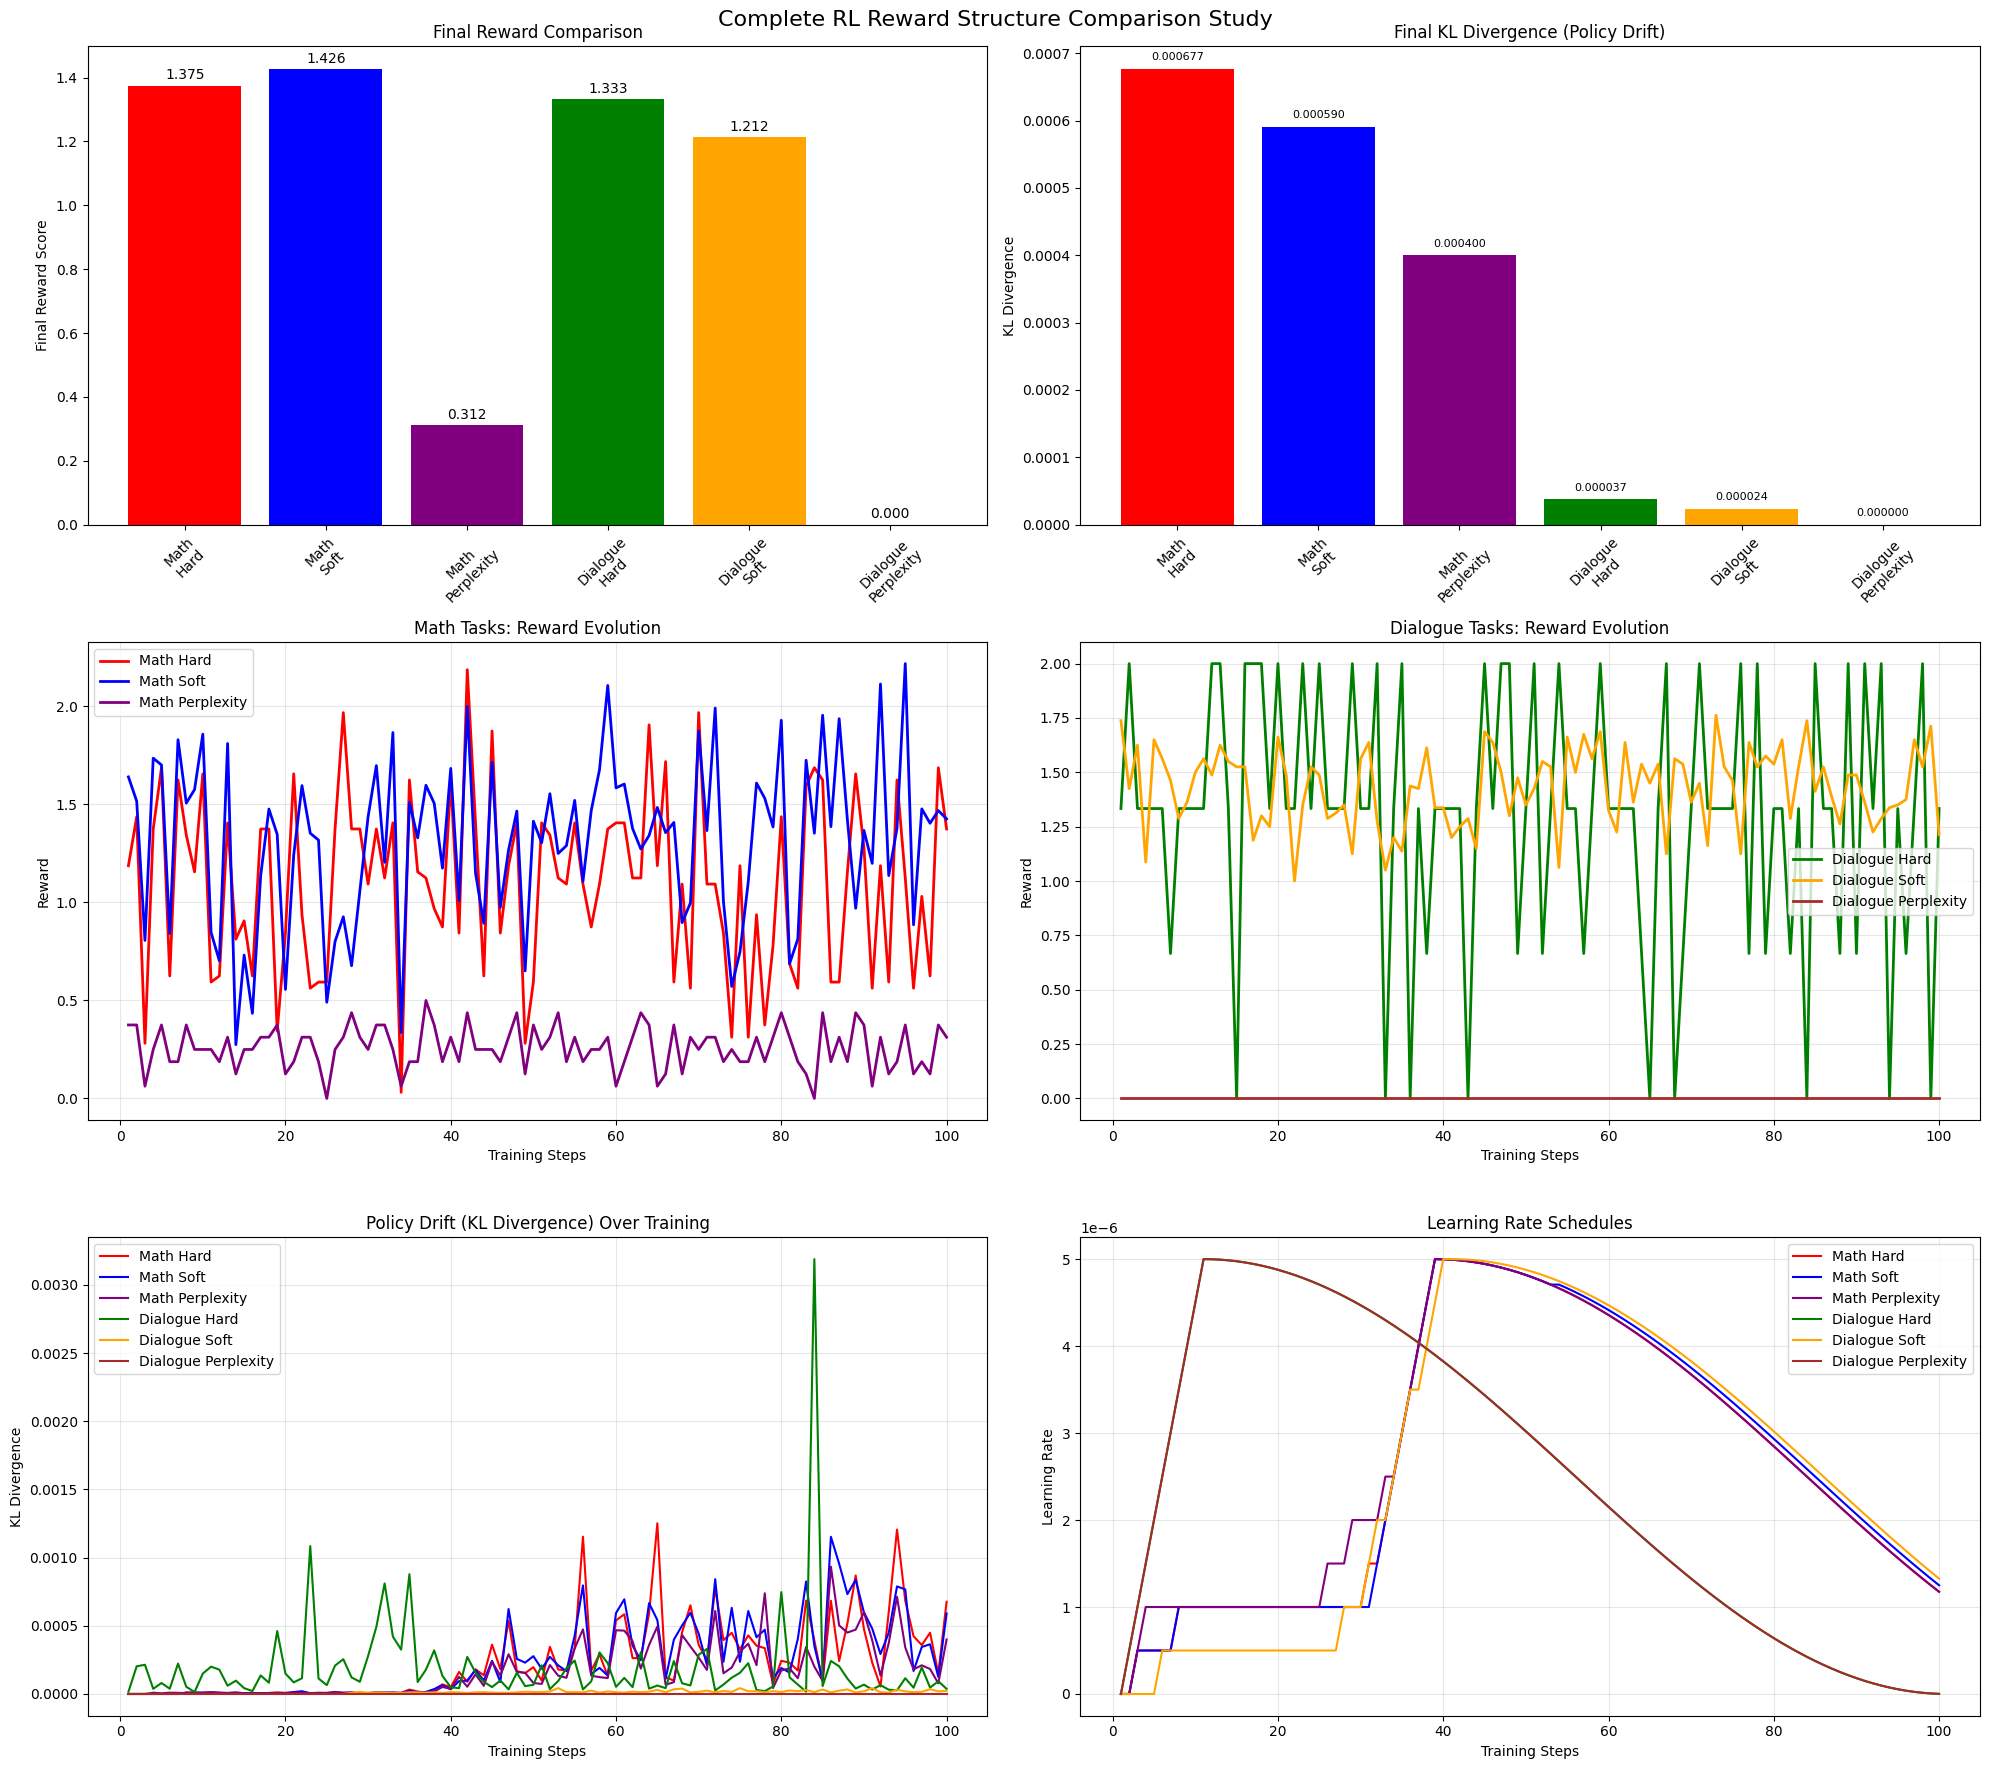


COMPREHENSIVE EXPERIMENTAL RESULTS

Math Hard:
  Final Reward: 1.3750
  Final KL: 0.000677
  Training Steps: 100
  Reward Change: +0.1875

Math Soft:
  Final Reward: 1.4264
  Final KL: 0.000590
  Training Steps: 100
  Reward Change: -0.2143

Math Perplexity:
  Final Reward: 0.3125
  Final KL: 0.000400
  Training Steps: 100
  Reward Change: -0.0625

Dialogue Hard:
  Final Reward: 1.3333
  Final KL: 0.000037
  Training Steps: 100
  Reward Change: +0.0000

Dialogue Soft:
  Final Reward: 1.2125
  Final KL: 0.000024
  Training Steps: 100
  Reward Change: -0.5250

Dialogue Perplexity:
  Final Reward: 0.0000
  Final KL: 0.000000
  Training Steps: 100
  Reward Change: +0.0000


In [42]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def load_all_experiments():
    """Load all 4 experiments for comparison"""
    experiments = {
        'Math Hard': r"D:\03 Programs\LossFunk\outputs_mathhard\math_hard_rewards\checkpoint-100",
        'Math Soft': r"D:\03 Programs\LossFunk\outputs_mathsoft\math_soft_rewards\checkpoint-100", 
        'Math Perplexity': r"D:\03 Programs\LossFunk\outputs_math_perplexity\math_perplexity_rewards\checkpoint-100",
        'Dialogue Hard': r"D:\03 Programs\LossFunk\outputs_dialoguehard\dialogue_hard_rewards\checkpoint-100",
        'Dialogue Soft': r"D:\03 Programs\LossFunk\outputs_dialoguesoft\dialogue_soft_rewards\checkpoint-100",
        'Dialogue Perplexity': r"D:\03 Programs\LossFunk\outputs_dialogue_perplexity\dialogue_perplexity_rewards\checkpoint-100"
    }
    
    data = {}
    for name, path in experiments.items():
        try:
            trainer_state_path = os.path.join(path, "trainer_state.json")
            with open(trainer_state_path, 'r') as f:
                trainer_state = json.load(f)
            data[name] = pd.DataFrame(trainer_state['log_history'])
            print(f"Loaded {name}: {len(data[name])} steps")
        except Exception as e:
            print(f"Failed to load {name}: {e}")
    
    return data

def plot_comprehensive_comparison(data):
    """Create comprehensive 6-way comparison"""
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Complete RL Reward Structure Comparison Study', fontsize=16)
    
    colors = ['red', 'blue', 'purple', 'green', 'orange', 'brown', 'pink', 'gray', 'olive']  # Added more colors
    
    # Plot 1: Final Rewards Comparison
    ax1 = axes[0, 0]
    names = []
    final_rewards = []
    for i, (name, df) in enumerate(data.items()):
        if len(df) > 0:
            names.append(name.replace(' ', '\n'))
            final_rewards.append(df['reward'].iloc[-1])
    
    bars = ax1.bar(names, final_rewards, color=colors[:len(names)])
    ax1.set_title('Final Reward Comparison')
    ax1.set_ylabel('Final Reward Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, final_rewards):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Plot 2: KL Divergence Comparison  
    ax2 = axes[0, 1]
    final_kl = []
    for name, df in data.items():
        if len(df) > 0:
            final_kl.append(df['kl'].iloc[-1])
    
    bars = ax2.bar(names, final_kl, color=colors[:len(names)])
    ax2.set_title('Final KL Divergence (Policy Drift)')
    ax2.set_ylabel('KL Divergence')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars, final_kl):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00001,
                f'{value:.6f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 3: Math Experiments - Reward Evolution
    ax3 = axes[1, 0]
    math_color_idx = 0
    for name, df in data.items():
        if 'Math' in name and len(df) > 0:
            ax3.plot(df['step'], df['reward'], label=name, linewidth=2, color=colors[math_color_idx])
            math_color_idx += 1
    ax3.set_title('Math Tasks: Reward Evolution')
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Reward')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Dialogue Experiments - Reward Evolution  
    ax4 = axes[1, 1]
    dialogue_color_idx = 0
    for name, df in data.items():
        if 'Dialogue' in name and len(df) > 0:
            ax4.plot(df['step'], df['reward'], label=name, linewidth=2, color=colors[dialogue_color_idx + 3])
            dialogue_color_idx += 1
    ax4.set_title('Dialogue Tasks: Reward Evolution')
    ax4.set_xlabel('Training Steps')
    ax4.set_ylabel('Reward')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: All KL Divergence Evolution
    ax5 = axes[2, 0]
    for i, (name, df) in enumerate(data.items()):
        if len(df) > 0:
            ax5.plot(df['step'], df['kl'], label=name, linewidth=1.5, color=colors[i % len(colors)])
    ax5.set_title('Policy Drift (KL Divergence) Over Training')
    ax5.set_xlabel('Training Steps')
    ax5.set_ylabel('KL Divergence')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Learning Rate Schedules
    ax6 = axes[2, 1]
    for i, (name, df) in enumerate(data.items()):
        if len(df) > 0:
            ax6.plot(df['step'], df['learning_rate'], label=name, linewidth=1.5, color=colors[i % len(colors)])
    ax6.set_title('Learning Rate Schedules')
    ax6.set_xlabel('Training Steps') 
    ax6.set_ylabel('Learning Rate')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Run the analysis
all_data = load_all_experiments()
fig = plot_comprehensive_comparison(all_data)
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("COMPREHENSIVE EXPERIMENTAL RESULTS")
print("="*80)

for name, df in all_data.items():
    if len(df) > 0:
        print(f"\n{name}:")
        print(f"  Final Reward: {df['reward'].iloc[-1]:.4f}")
        print(f"  Final KL: {df['kl'].iloc[-1]:.6f}")
        print(f"  Training Steps: {len(df)}")
        
        # Calculate improvement
        if len(df) > 1:
            improvement = df['reward'].iloc[-1] - df['reward'].iloc[0]
            print(f"  Reward Change: {improvement:+.4f}")